# MAST30034 Project 1
## Analysis

In [25]:
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/14 13:30:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [26]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt

### Geopandas visualisation
#### Average tip earnings per taxi zone

In [3]:
sf = gpd.read_file("../../Project 1/Data/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../../Project 1/Data/taxi_zones/taxi+_zone_lookup.csv")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()


In [4]:
sdf = spark.read.parquet('processed')
geo_tips = sdf[['pickup_location', 'tip_amount']] \
                .groupby('pickup_location') \
                .agg(
                    {
                        'tip_amount': 'sum', # sum over total amount earned
                        'pickup_location': 'count' # count number of instances from sample
                    }
                )
geo_tips = geo_tips.withColumn('avg_tip_amount', geo_tips['sum(tip_amount)'] / geo_tips['count(pickup_location)'])
geo_tips = geo_tips.withColumnRenamed('count(pickup_location)', 'total_trips').withColumnRenamed('sum(tip_amount)', 'total_tips')
df = geo_tips.toPandas()
df = df \
    .merge(gdf[['LocationID', 'geometry']], left_on='pickup_location', right_on='LocationID') \
    .drop('LocationID', axis=1)

In [5]:
map = folium.Map(location=[40.73, -73.74], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='Average Tip Earnings (USD)', # name of plot
    data=df, # data source
    columns=['pickup_location','avg_tip_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average Tip Earnings (USD)'
)
c.add_to(map)
map.save("/outputs/Average_tip_amount.html")

In [6]:
df['avg_tip_amount'].idxmax()
df.loc[[103]]
df = df.drop(103)

In [7]:
map = folium.Map(location=[40.73, -73.74], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='Average Tip Earnings (USD) (outlier removed)', # name of plot
    data=df, # data source
    columns=['pickup_location','avg_tip_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average Tip Earnings (USD)'
)
c.add_to(map)
map.save("/outputs/Average_tip_amount_drop_outlier.html")

### Frequency of particular tip amounts

Text(0.5, 0, 'tip_amount (USD)')

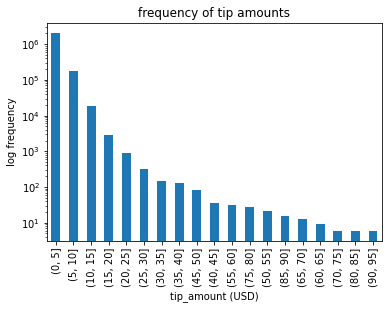

In [131]:
import pandas as pd
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df['binned'] = pd.cut(df["tip_amount"], bins= range(0, 100, 5))
ax = df['binned'].value_counts().plot(kind='bar', logy = True, title = 'frequency of tip amounts')
ax.set_ylabel("log frequency")
ax.set_xlabel("tip_amount (USD)")

In [7]:
pctge_non_zero_tips = round(((df['tip_amount'] == 0).sum() / df['tip_amount'].count())*100, 3)
pctge_non_zero_tips


34.22

### Correlation Matrix

In [27]:
from pyspark.sql.functions import *
taxi = spark.read.parquet('../../Project 1/DataFrames/taxi')
weather = spark.read.parquet('../../Project 1/DataFrames/weather')
taxi = taxi.withColumn("pickup_date",to_date(col("pickup_time")))
taxi = taxi.drop("pickup_time", "dropoff_time")
sdf = taxi.join(weather,taxi.pickup_date ==  weather.date,"inner")
sdf = sdf.drop('date')

22/08/14 13:30:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/14 13:30:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


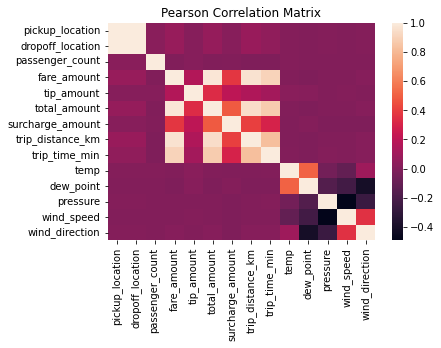

In [28]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns


cor_sdf = sdf.drop('pickup_date')
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cor_sdf.columns, outputCol=vector_col)
df_vector = assembler.transform(cor_sdf).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

sns.heatmap(corrmatrix, yticklabels = cor_sdf.columns, xticklabels = cor_sdf.columns)
plt.title('Pearson Correlation Matrix')
plt.show()

From a tipping perspective, we can see that the main categories it is correlated with is fare_amount, total_amount and surcharge_amount, this is obvious as total_amount is the some of the other 3. (pickup_location, dropoff_location) and (temp, dew_point) are pairs heavily correlated (with reality supporting this finding. To see which metrics are correlated with tipping, the variables mentioned wil be dropped:

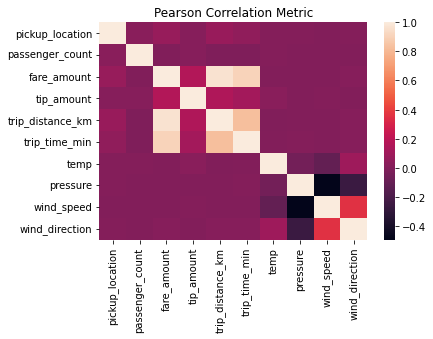

In [31]:
cor_sdf = sdf.drop('dropoff_location', 'dew_point', 'pickup_date', 'total_amount', 'surcharge_amount')
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cor_sdf.columns, outputCol=vector_col)
df_vector = assembler.transform(cor_sdf).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

sns.heatmap(corrmatrix, yticklabels = cor_sdf.columns, xticklabels = cor_sdf.columns)
plt.title('Pearson Correlation Metric')
plt.show()

It appears as though, fare amount, trip distance and trip time are the most correlated variables with tipping, These will be further investigated. To check if there is any other weeker correlations, we will remove these. There is also quite faintly a small correlation between temp and tips which will also be investigated

### Tip_amount vs fare_amount:

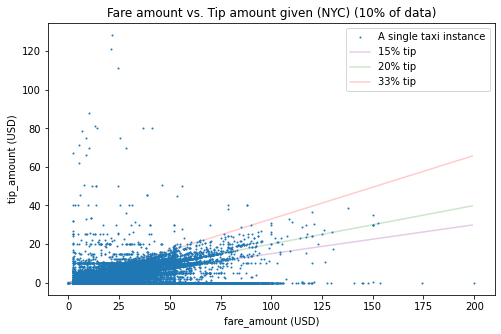

In [137]:
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df = df.sample(frac=0.10, replace=True, random_state=1)
x = df['fare_amount']
y = df['tip_amount']
line = range(200)
tip_15_line = [0.15*x for x in range(200)]
tip_20_line = [0.20*x for x in range(200)]
tip_33_line = [0.33*x for x in range(200)]
fig, ax = plt.subplots(figsize=(8,5))
fare_df = pd.DataFrame({"x": x, "y":y})
#You pass the wanted axis to the ax argument
fare_df.plot(kind='scatter', x= 'x', y= 'y', s = 1, title="Fare amount vs. Tip amount given (NYC) (10% of data)", ax=ax) 
ax.plot(line, tip_15_line, zorder=-1, color = 'purple', alpha = 0.2)
ax.plot(line, tip_20_line, zorder=-1, color = 'green', alpha = 0.2)
ax.plot(line, tip_33_line, zorder=-1, color = 'red', alpha = 0.2)
ax.set_xlabel("fare_amount (USD)")
ax.set_ylabel("tip_amount (USD)")
plt.legend(['A single taxi instance', '15% tip', '20% tip', '33% tip'])

In [93]:
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df['between_15_and_33'] = np.where((df['tip_amount'] >= df['fare_amount']*0.15) & (df['tip_amount'] <= df['fare_amount']*0.33), True, False)
perc_between_15_and_33 = (df.between_15_and_33.value_counts().loc[True] / df.between_15_and_33.count())*100
perc_between_15_and_33

51.88529502770665

In [95]:
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df = df.drop(df[df.tip_amount == 0].index)
df['between_15_and_33'] = np.where((df['tip_amount'] >= df['fare_amount']*0.15) & (df['tip_amount'] <= df['fare_amount']*0.33), True, False)
perc_between_15_and_33 = (df.between_15_and_33.value_counts().loc[True] / df.between_15_and_33.count())*100
perc_between_15_and_33

78.87713727265447

The above output shows the distribution of fare amount verses the tip given, two lines representing 10% and 20% tip (% of fare amount) have been overlaid, due to the extremely large datset, 10% was used for graph, which showed the relationship alot better. Visable from this (and the above calculation, majority (~52%) of tips are between 15 and 33% of the fare amount. if you only include people who tipped a non zero amount, this number rises to ~79%

### Tip amounnt vs Trip_distance

slope, intercept, r^2 = 0.3312205327128886 1.1467870798828548 0.5832158802940952


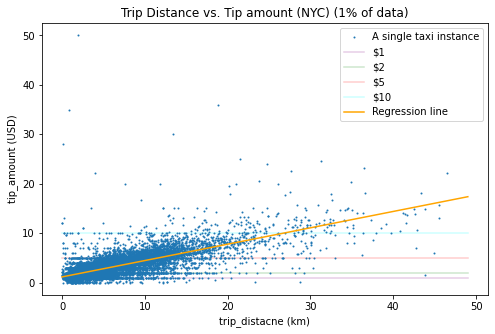

In [20]:
from scipy.stats import linregress
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df_non_zero_tips = df.drop(df[df.tip_amount == 0].index)
df_non_zero_tips = df_non_zero_tips.sample(frac=0.01, replace=True, random_state=1)
x = df_non_zero_tips['trip_distance_km']
y = df_non_zero_tips['tip_amount']
fig, ax = plt.subplots(figsize=(8,5))
fare_df = pd.DataFrame({"x": x, "y":y})
line = range(50)
tip_1usd = [1 for x in range(50)]
tip_2usd = [2 for x in range(50)]
tip_5usd = [5 for x in range(50)]
tip_10usd = [10 for x in range(50)]
p = np.poly1d(np.polyfit(x, y, 1))
tip_reg = [p(x) for x in range(50)]
#You pass the wanted axis to the ax argument
fare_df.plot(kind='scatter', x= 'x', y= 'y', s = 1, title="Trip Distance vs. Tip amount (NYC) (1% of data)", ax=ax) 
ax.plot(line, tip_1usd, zorder=-1, color = 'purple', alpha = 0.2)
ax.plot(line, tip_2usd, zorder=-1, color = 'green', alpha = 0.2)
ax.plot(line, tip_5usd, zorder=-1, color = 'red', alpha = 0.2)
ax.plot(line, tip_10usd, zorder=-1, color = 'aqua', alpha = 0.2)
ax.plot(line, tip_reg, zorder=1, color = 'orange')
ax.set_xlabel("trip_distacne (km)")
ax.set_ylabel("tip_amount (USD)")
plt.legend(['A single taxi instance', '$1', '$2', '$5', '$10', 'Regression line'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("slope, intercept, r^2 =", slope, intercept, r_value**2)

The above output shows the relationship between Trip distance and tips give, three lines representing 1, 2, 5 and 10 dollars have been overlaid as well as a line of regression, to better see this relationship, 1% of thr data was graphed. The output shows that people often will tip whole number dollars, however tips of one and two dollars are slightly more common when the trip distance is shorter compared to tipping 5 and 10 dollars. A regression line has also been fitted to show that there is a clear correlation (r^2 = 0.58) between distance and tips with approximately 33c being given for every kilometer driven, startng with approximately $1.10 at the start of the trip.

### Tip Amount vs Time Travelled

slope, intercept, r^2 = 0.13969073205921795 0.7940918527190504 0.5070787203797881


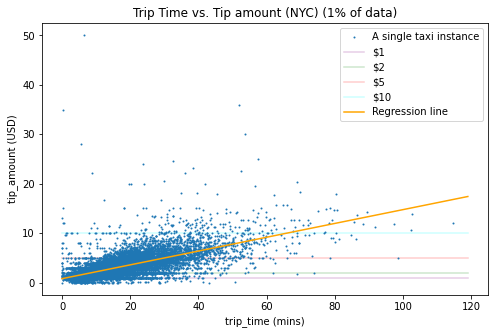

In [21]:
from scipy.stats import linregress
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df_non_zero_tips = df.drop(df[df.tip_amount == 0].index)
df_non_zero_tips = df_non_zero_tips.sample(frac=0.01, replace=True, random_state=1)
x = df_non_zero_tips['trip_time_min']
y = df_non_zero_tips['tip_amount']
fig, ax = plt.subplots(figsize=(8,5))
fare_df = pd.DataFrame({"x": x, "y":y})
line = range(120)
tip_1usd = [1 for x in range(120)]
tip_2usd = [2 for x in range(120)]
tip_5usd = [5 for x in range(120)]
tip_10usd = [10 for x in range(120)]
p = np.poly1d(np.polyfit(x, y, 1))
tip_reg = [p(x) for x in range(120)]
#You pass the wanted axis to the ax argument
fare_df.plot(kind='scatter', x= 'x', y= 'y', s = 1, title="Trip Time vs. Tip amount (NYC) (1% of data)", ax=ax) 
ax.plot(line, tip_1usd, zorder=-1, color = 'purple', alpha = 0.2)
ax.plot(line, tip_2usd, zorder=-1, color = 'green', alpha = 0.2)
ax.plot(line, tip_5usd, zorder=-1, color = 'red', alpha = 0.2)
ax.plot(line, tip_10usd, zorder=-1, color = 'aqua', alpha = 0.2)
ax.plot(line, tip_reg, zorder=1, color = 'orange')
ax.set_xlabel("trip_time (mins)")
ax.set_ylabel("tip_amount (USD)")
plt.legend(['A single taxi instance', '$1', '$2', '$5', '$10', 'Regression line'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("slope, intercept, r^2 =", slope, intercept, r_value**2)

The above output shows the relationship between Trip time and tips give, three lines representing 1, 2, 5 and 10 dollars have been overlaid as well as a line of regression. To better see this relationship, 1% of thr data was graphed. The output shows that people often will tip whole number dollars, however tips of one and two dollars are slightly more common when the trip distance is shorter compared to tipping 5 and 10 dollars. A regression line has also been fitted to show that there is a clear correlation (r^2 = 0.51) between time and tips with approximately 13c being given for every min driven, startng with approximately 79c at the start of the trip.

### Tips vs Temp

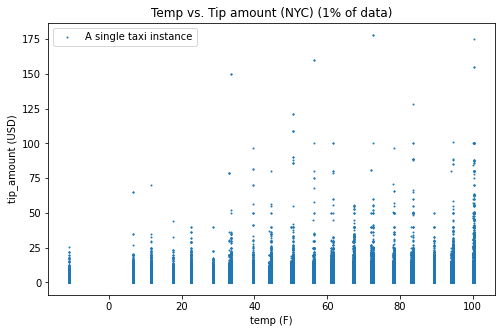

In [38]:
from scipy.stats import linregress
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df_non_zero_tips = df.drop(df[df.tip_amount == 0].index)
df_non_zero_tips = df_non_zero_tips.sample(frac=1, replace=True, random_state=1)
x = df_non_zero_tips['temp']
y = df_non_zero_tips['tip_amount']
fig, ax = plt.subplots(figsize=(8,5))
fare_df = pd.DataFrame({"x": x, "y":y})

fare_df.plot(kind='scatter', x= 'x', y= 'y', s = 1, title="Temp vs. Tip amount (NYC)", ax=ax) 
ax.set_xlabel("temp (F)")
ax.set_ylabel("tip_amount (USD)")

In [98]:
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
all_df = df.groupby('temp')['tip_amount'].count()
nonzero_df = df.drop(df[df.tip_amount == 0].index)
nonzero_df = nonzero_df.groupby('temp')['tip_amount'].count()
all_df = all_df.to_frame().reset_index()
nonzero_df = nonzero_df.to_frame().reset_index()
nonzero_df['ratio'] = nonzero_df["tip_amount"] / all_df["tip_amount"]

slope, intercept, r^2 = 0.0005683844037552284 0.6283254738658077 0.0811098992311558


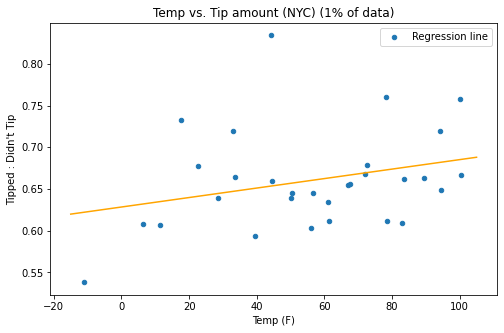

In [108]:
x = nonzero_df['temp']
y = nonzero_df['ratio']
fig, ax = plt.subplots(figsize=(8,5))
fare_df = pd.DataFrame({"x": x, "y":y})

line = range(-15, 106)
p = np.poly1d(np.polyfit(x, y, 1))
tip_reg = [p(x) for x in range(-15, 106)]

fare_df.plot(kind='scatter', x= 'x', y= 'y', title="Temp vs. Tip amount (NYC)", ax=ax) 
ax.set_xlabel("Temp (F)")
ax.set_ylabel("Tipped : Didn't Tip")
ax.plot(line, tip_reg, zorder=1, color = 'orange')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("slope, intercept, r^2 =", slope, intercept, r_value**2)
plt.legend(['', 'Regression line'])